In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display as ld
import random
import pickle, itertools, sklearn, pandas as pd, seaborn as sn
from scipy.spatial import distance
from scipy import spatial
import csv

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

import os 
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import sys
import tensorflow as tf
import keras

from keras.models import Model, load_model, Sequential
from keras import backend as K
from keras.utils.vis_utils import plot_model

from keras.layers import Input, Dense, InputLayer, InputLayer, Concatenate, Flatten, Reshape, Lambda, Embedding, dot
from keras.layers import Conv1D, MaxPooling1D, UpSampling1D
from keras.layers import BatchNormalization, GlobalMaxPool1D, Activation, concatenate
from keras.losses import binary_crossentropy

In [3]:
# Get audio with genres from Metadata list

# tsv_file = open("./mtg/data/autotagging_genre.tsv")
tsv_file = open("./mtg/data/raw_30s_cleantags.tsv")
read_tsv = csv.reader(tsv_file, delimiter="\t")

track_genre_dict = {}
for row in read_tsv:
    # print(row)
    name = row[0][6:len(row[0])] # cut track_
    if name != 'ID': 
        for c in name:               # cut leading 0s
            if c == '0':
                name = name[1:]
            else:
                break
        name = name + '.npy'
        # name = name + '.mp3'
    
        genre = []
        for ele in row:
            if 'genre' in ele:
                genre.append(ele[8:]) # cut genre__

        track_genre_dict[name] = genre
    
# track_genre = track_genre[1:] # cut first one, tag 'ID, Genre'
# print(track_genre_dict)

In [5]:
# GET SONGS

# dir = os.getcwd()+"/song/"
# # print(dir)

# songs1 = []
# songs2 = []
# songs3 = []
# # y_col = []

# for root, dirs, files in os.walk(dir, topdown=False) :
#     # print(files)
#     for name in files:
#         # print(name)
#         if name in track_genre_dict:
#             fullname = os.path.join(root, name)
#             # print(fullname)
        
#             if fullname.find(".mp3") != -1 :
#                 genre_list = track_genre_dict.get(name)
#                 if 'bass' in genre_list and 'piano' not in genre_list and 'guitar' not in genre_list:
#                     songs1.append(fullname)
#                     # y_col.append(0)
#                 elif 'piano' in genre_list and 'bass' not in genre_list and 'guitar' not in genre_list:
#                     songs2.append(fullname)
#                     # y_col.append(1)
#                 elif 'guitar' in genre_list and 'piano' not in genre_list and 'bass' not in genre_list:
#                     songs3.append(fullname)
#                     # y_col.append(2)
#                 # else:
#                     # y_col.append(3)

# # y_col = np.array(y_col)
# # spectrums = np.array(spectrums)
# songs1 = np.array(songs1)
# songs2 = np.array(songs2)
# songs3 = np.array(songs3)
# print(songs3)

In [30]:
dir = os.getcwd()+"/mel_spec/"
# print(dir)

spectrums = []
spectrums_filename = []
y_col = []

for root, dirs, files in os.walk(dir, topdown=False) :
    # print(files)
    for name in files:
        # print(name)
        if name in track_genre_dict:
            fullname = os.path.join(root, name)
            # print(fullname)
        
            if fullname.find(".npy") != -1 :
                genre_list = track_genre_dict.get(name)
                if ('hiphop' in genre_list and 'instrumentalhiphop' not in genre_list and 
                   'rock' not in genre_list and 'poprock' not in genre_list and
                   'electronic' not in genre_list):
                    spectrums.append(fullname)
                    spectrums_filename.append(name)
                    y_col.append(0)
                elif ('rock' in genre_list and 'instrumentalrock' not in genre_list and 
                      'pop' not in genre_list and 'ambient' not in genre_list and 
                      'southernrock' not in genre_list):
                    spectrums.append(fullname)
                    spectrums_filename.append(name)
                    y_col.append(1)
                elif 'classical' in genre_list and len(genre_list) == 1 :
                    spectrums.append(fullname)
                    spectrums_filename.append(name)
                    y_col.append(2)
                # else:
                    # y_col.append(3)

y_col = np.array(y_col)
spectrums = np.array(spectrums)
spectrums_filename = np.array(spectrums_filename)

# print(spectrums)
# print(len(y_col))

# print(y_col)

# Generate positive samples

spec1 = spectrums[np.where(y_col==0)]    # all pop file names
spec2 = spectrums[np.where(y_col==1)]
spec3 = spectrums[np.where(y_col==2)]

# spec1 = spectrums_filename[np.where(y_col==0)]    # all pop file names
# spec2 = spectrums_filename[np.where(y_col==1)]
# spec3 = spectrums_filename[np.where(y_col==2)]

print(len(spec1))   
print(len(spec2))   
print(len(spec3))   

76
140
43


In [31]:
# for name in spec2:
#     genre_list = track_genre_dict.get(name)
#     print(name)
#     print(genre_list)

In [33]:
# Test spectrums, last 10 spec
test_1_spec = spec1[-10:]
test_2_spec = spec2[-10:]
test_3_spec = spec3[-10:]

# Save test data
f = open(os.getcwd()+"/test_specs.pkl", 'wb')
pickle.dump([test_1_spec, test_2_spec, test_3_spec], f)
f.close()

# Train spectrums, first 30 spec
train_1_spec = spec1[:30]
train_2_spec = spec2[:30]
train_3_spec = spec3[:30]

# print(test_pop_spec)
# print(pop_spec)

# Generate positive samples
positive1 = list(itertools.combinations(spec1, 2)) # all pop file name pairs
positive2 = list(itertools.combinations(spec2, 2))
positive3 = list(itertools.combinations(spec3, 2))

# print(positive_pop)

# Generate negative samples
negative1 = list(itertools.product(spec1, spec2))
negative2 = list(itertools.product(spec1, spec3))
negative3 = list(itertools.product(spec2, spec3))

# print(negative1)

# Create pairs of spectrums and set target label for them. 
# Target output is 1 if pair of spectrums are in same genre else it is 0.
# spec_X1 = []
# spec_X2 = []
# spec_y = []
# positive_samples = positive_pop + positive_electr + positive_classic
# negative_samples = negative1 + negative2 + negative3

print(len(positive1))
print(len(positive2))
print(len(positive3))
print(len(negative1))
print(len(negative2))
print(len(negative3))

2850
9730
903
10640
3268
6020


In [34]:
lis = list(spec1) + list(spec2) + list(spec3)
# print(len(lis))
lshape = []
for fname in lis :
    mspec = np.load(fname)
    lshape.append(mspec.shape[1])
    
#     if mspec.shape[1] == 96:
#         print(fname)
        
print(min(lshape))

lowest_shape = min(lshape) - 1
print(lowest_shape)

1476
1475


In [39]:
def add_pairs(x, X1, X2, Y, f, label, num):
    counter = 0
    for fname in x :
        if counter == num:
            break

        mspec = np.load(fname[0])
        mspec = mspec[:, :f]
        X1.append(mspec)
        mspec = np.load(fname[1])
        mspec = mspec[:, :f]
        X2.append(mspec)
        Y.append(label)

        counter += 1
    return X1, X2, Y

In [36]:
spec_X1 = []
spec_X2 = []
spec_y = []

num_pos = 500
num_neg = 500

spec_X1, spec_X2, spec_y = add_pairs(positive1, spec_X1, spec_X2, spec_y, lowest_shape, 1, num_pos)
spec_X1, spec_X2, spec_y = add_pairs(positive2, spec_X1, spec_X2, spec_y, lowest_shape, 1, num_pos)
spec_X1, spec_X2, spec_y = add_pairs(positive3, spec_X1, spec_X2, spec_y, lowest_shape, 1, num_pos)

spec_X1, spec_X2, spec_y = add_pairs(negative1, spec_X1, spec_X2, spec_y, lowest_shape, 0, num_neg)
spec_X1, spec_X2, spec_y = add_pairs(negative2, spec_X1, spec_X2, spec_y, lowest_shape, 0, num_neg)
spec_X1, spec_X2, spec_y = add_pairs(negative3, spec_X1, spec_X2, spec_y, lowest_shape, 0, num_neg)

In [38]:
spec_y = np.array(spec_y)

# for l in spec_X1:
#     print(l.shape)

spec_X1 = np.array(spec_X1)
spec_X2 = np.array(spec_X2)

spec_X1 = spec_X1.reshape((len(spec_y), 96, lowest_shape)) # spect of size 
spec_X2 = spec_X2.reshape((len(spec_y), 96, lowest_shape))

spec_X1 = 1 - spec_X1/255
spec_X2 = 1 - spec_X2/255

print("Song Spec data : ", spec_X1.shape, spec_X2.shape, spec_y.shape)

Song Spec data :  (3000, 96, 1475) (3000, 96, 1475) (3000,)


In [40]:
def contrastive_loss(y, preds, margin=1):
    # explicitly cast the true class label data type to the predicted
    # class label data type (otherwise we run the risk of having two
    # separate data types, causing TensorFlow to error out)
    y = tf.cast(y, preds.dtype)
    # calculate the contrastive loss between the true labels and
    # the predicted labels
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)
    # return the computed contrastive loss to the calling function
    return loss

In [41]:
# Train autoencoder and save encoder model and encodings
def train_songs_encoder(X1, X2, y) :
    # hyper-parameters
    n_filters = 64
    filter_width = 3
    dilation_rates = [2**i for i in range(8)] 
    
    history_seq = Input((96, lowest_shape))
    x = history_seq
    
    skips = []
    count = 0
    for dilation_rate in dilation_rates:
        x = Conv1D(filters=n_filters,
                    kernel_size=filter_width, 
                    padding='causal',
                    dilation_rate=dilation_rate, activation='relu', name="conv1d_dilation_"+str(dilation_rate))(x)
        
        x = BatchNormalization()(x)
        
    out = Conv1D(32, 16, padding='same')(x)
    out = BatchNormalization()(out)
    out = Activation('tanh')(out)
    out = GlobalMaxPool1D()(out)
    
    model = Model(history_seq, out)
    model.compile(loss='mse', optimizer='adam')
    
    input1 = Input((96, lowest_shape), name="Positive Input")
    input2 = Input((96, lowest_shape), name="Negative Input")


    # Create left and right twin encoded models
    left_model = model(input1)
    right_model = model(input2)
    
    concat = concatenate([left_model, right_model], axis=1)

    siamese_net = Model([input1, input2], concat)

    siamese_net.compile(optimizer='adam', loss=contrastive_loss)

    print(siamese_net.summary())

    # Fit model
    siamese_net.fit([X1, X2], y, epochs=35, batch_size=256, verbose=1)

    model.save(os.getcwd()+"/song_encoder.h5")
    siamese_net.save(os.getcwd()+"/song_siamese_model.h5")
    
    return model, siamese_net


# train model
model, siamese_model = train_songs_encoder(spec_X1, spec_X2, spec_y)

# model.save(os.getcwd()+"/song_encoder.h5")
# siamese_model.save(os.getcwd()+"/song_siamese_model.h5")

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Positive Input (InputLayer)     [(None, 96, 1475)]   0                                            
__________________________________________________________________________________________________
Negative Input (InputLayer)     [(None, 96, 1475)]   0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 32)           404704      Positive Input[0][0]             
                                                                 Negative Input[0][0]             
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 64)           0           model[0][0]                

In [42]:
# # Load models
# model = load_model(os.getcwd()+"/song_encoder.h5", compile= False)
# siamese_model = load_model(os.getcwd()+"/song_siamese_model.h5", compile= False)

# # Load test data
# f = open(os.getcwd()+"/test_specs.pkl", 'rb')
# # f = open(os.getcwd()+"/test(train)_specs.pkl", 'rb')
# test_1_spec, test_2_spec, test_3_spec = pickle.load(f)
# f.close()

test_1_spec = pop_spec[-10:]
test_2_spec = electr_spec[-10:]
test_3_spec = classic_spec[-10:]

# Read files
names = list(test_1_spec) + list(test_2_spec) + list(test_3_spec)

test_spec = []
for i in range(len(names)) :   
    s = np.load(names[i])
    s = s[:, :lowest_shape]
    test_spec.append(s)

r,c = test_spec[0].shape

# print(test_spec[0].shape)

test_spec = np.array(test_spec)
test_spec = test_spec.reshape((len(test_spec), r,c))
names = [x.split("/")[-1] for x in names]

test_spec = 1 - test_spec/255

In [43]:
# Predict
pred_frame = model.predict(test_spec)

print(pred_frame.shape)

(30, 32)


In [44]:
print(test_spec.shape)

# print(names)

l_1 = list(np.full(shape=10, fill_value=0, dtype=np.int))
l_2 = list(np.full(shape=10, fill_value=1, dtype=np.int))
l_3 = list(np.full(shape=10, fill_value=2, dtype=np.int))

test_spec_label = l_1 + l_2 + l_3
test_spec_label = np.array(test_spec_label)

print(test_spec_label.shape)


(30, 96, 1475)
(30,)


In [45]:
from  tqdm import tqdm

sim_mat = np.zeros((len(test_spec), len(test_spec)))
pred = []

for i in tqdm(range(len(test_spec))) :

    curr = test_spec[i:i+1]
    sim = model.predict(curr)
    sim = [1 - spatial.distance.cosine(sim[0], pred_frame[x]) for x in range(len(pred_frame))]
    sim = np.array(sim)

    sim[sim<0] = 0
    ind = np.copy(test_spec_label)
    
    ind = [x for _,x in sorted(zip(sim, ind))]
    ind = ind[::-1]
    ind = ind[:21]
    u, f = np.unique(ind, return_counts= True)
    best = u[np.argmax(f)]
    pred.append(best)
    sim_mat[i] = sim


conf_mat = confusion_matrix(test_spec_label, pred, normalize= 'true')
print("Accuracy on testset : ", np.trace(conf_mat)/np.sum(conf_mat))


100%|███████████████████████████████████████████| 30/30 [00:01<00:00, 18.76it/s]

Accuracy on testset :  0.5999999999999999


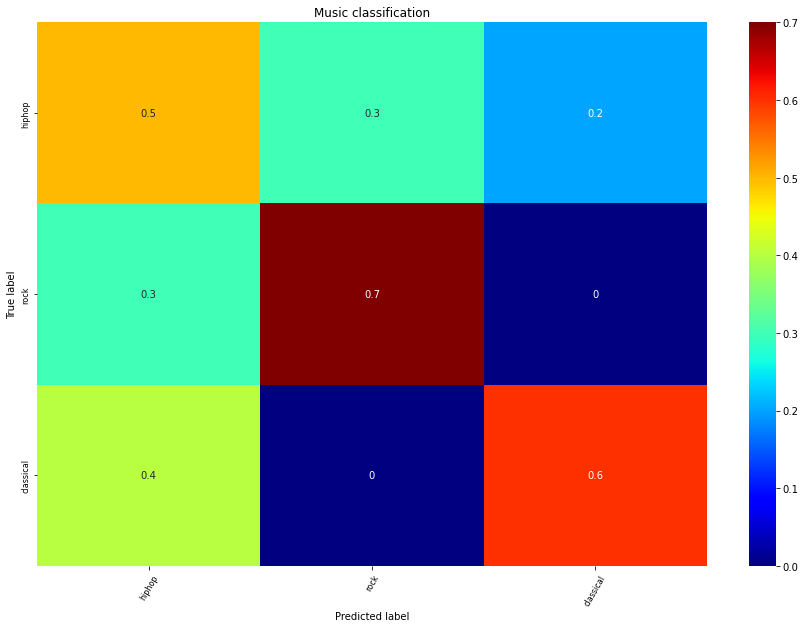

In [46]:
music_genre_dict = {0:'hiphop', 1:'rock', 2:'classical'}
u = np.unique(test_spec_label)

# Plot confusion matrix
conf_mat = pd.DataFrame(conf_mat, columns= [music_genre_dict[x] for x in u], index= [music_genre_dict[x] for x in u])
plt.figure(figsize = (15,10))
sn.heatmap(conf_mat, annot=True, annot_kws={"size": 10}, cmap='jet')
plt.tick_params(labelsize=8)
plt.xticks(rotation= 60)
plt.title("Music classification")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
# plt.savefig(os.getcwd()+"/ConfusionMatrix_test.png")
plt.close()